In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, balanced_accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')

In [20]:
# Function to plot class distribution
def plot_class_distribution(y, title):
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(unique, counts, color=['blue', 'orange'])
    plt.xticks(unique)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.show()

In [21]:
# Function to plot 3D data visualization
def plot_3d_data(X, y, title):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', edgecolor='k')
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title(title)
    plt.show()

In [22]:
def create_imbalanced_dataset(size, imbalance_ratio):
    X, y = make_classification(n_samples=size, n_features=3, n_informative=2, 
                               n_redundant=0, n_clusters_per_class=1, 
                               n_classes=2, weights=[1 - imbalance_ratio, imbalance_ratio],
                               flip_y=0, random_state=42)

    plot_class_distribution(y, f"Dataset with size {size} and imbalance ratio {imbalance_ratio}")
    plot_3d_data(X, y, f"Dataset with size {size} and imbalance ratio {imbalance_ratio}")

    return X, y

In [23]:
def evaluate_model(model, X, y, modifiers=None, sampling=None, dataset_size=1000, imbalance_ratio=0.1):
    results = {
        "Classifier Name": model.__class__.__name__,
        "Modifiers": modifiers if modifiers else "N/A",
        "Sampling": sampling if sampling else "N/A",
        "DatasetSize": dataset_size,
        "% imbalance": imbalance_ratio * 100
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    training_metrics = defaultdict(list)
    testing_metrics = defaultdict(list)
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Apply the selected sampling technique
        if sampling == "oversampling":
            ros = RandomOverSampler(random_state=42)
            X_train, y_train = ros.fit_resample(X_train, y_train)
        elif sampling == "upsampling":
            X_train, y_train = resample(X_train, y_train, replace=True, n_samples=len(X_train), random_state=42)
        elif sampling == "SMOTE":
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
        elif sampling == "undersampling":
            sampler = RandomUnderSampler(random_state=42)
            X_train, y_train = sampler.fit_resample(X, y)

        model.fit(X_train, y_train)
        
        # Training metrics
        y_train_pred = model.predict(X_train)
        training_metrics['precision'].append(precision_score(y_train, y_train_pred))
        training_metrics['accuracy'].append(accuracy_score(y_train, y_train_pred))
        training_metrics['recall'].append(recall_score(y_train, y_train_pred))
        training_metrics['f1'].append(f1_score(y_train, y_train_pred))
        training_metrics['balanced_accuracy'].append(balanced_accuracy_score(y_train, y_train_pred))
        
        # Testing metrics
        y_test_pred = model.predict(X_test)
        testing_metrics['precision'].append(precision_score(y_test, y_test_pred))
        testing_metrics['accuracy'].append(accuracy_score(y_test, y_test_pred))
        testing_metrics['recall'].append(recall_score(y_test, y_test_pred))
        testing_metrics['f1'].append(f1_score(y_test, y_test_pred))
        testing_metrics['balanced_accuracy'].append(balanced_accuracy_score(y_test, y_test_pred))
    
    # Add metrics to results dictionary
    results.update({
        "Training precision": np.mean(training_metrics['precision']),
        "Training accuracy": np.mean(training_metrics['accuracy']),
        "Training recall": np.mean(training_metrics['recall']),
        "Training f1": np.mean(training_metrics['f1']),
        "Training balanced accuracy": np.mean(training_metrics['balanced_accuracy']),
        "Training size": len(y_train),
        
        "Testing precision": np.mean(testing_metrics['precision']),
        "Testing accuracy": np.mean(testing_metrics['accuracy']),
        "Testing recall": np.mean(testing_metrics['recall']),
        "Testing f1": np.mean(testing_metrics['f1']),
        "Testing balanced accuracy": np.mean(testing_metrics['balanced_accuracy']),
        "Testing size": len(y_test)
    })
    
    return results

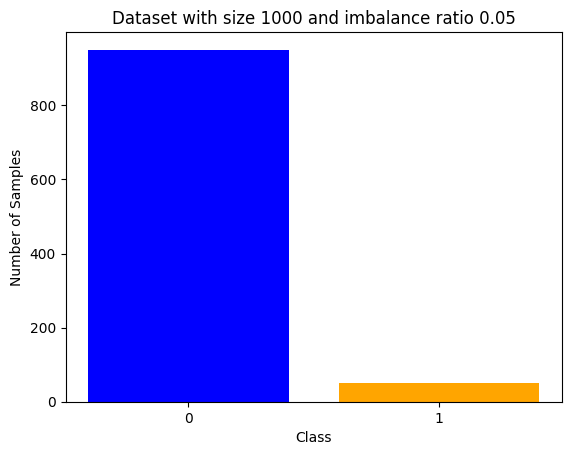

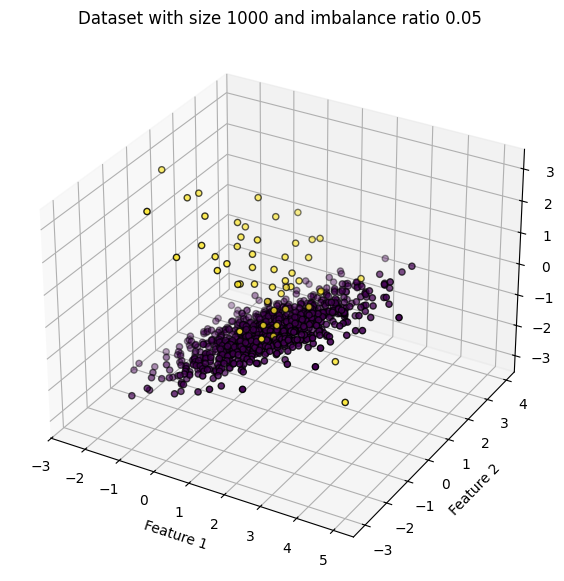

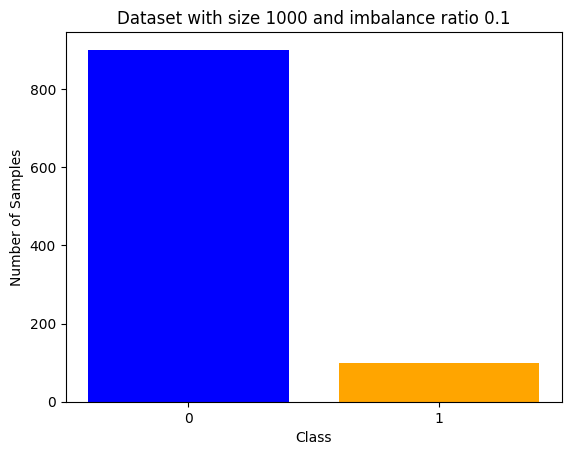

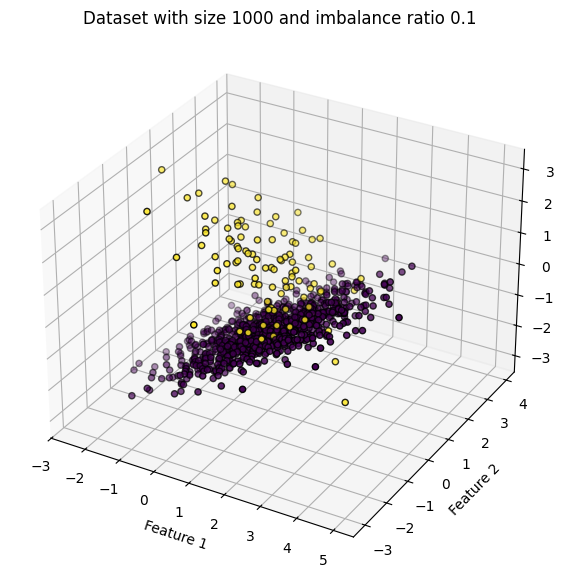

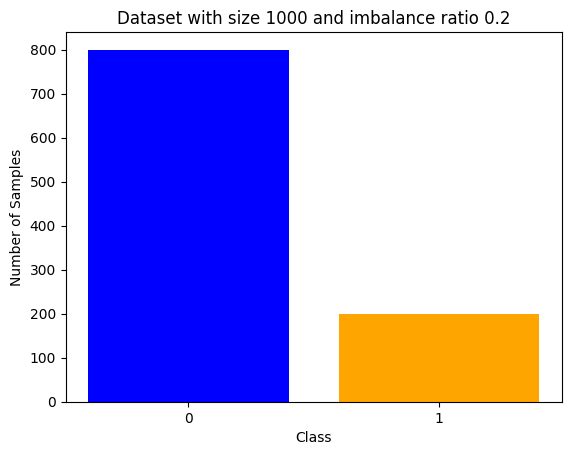

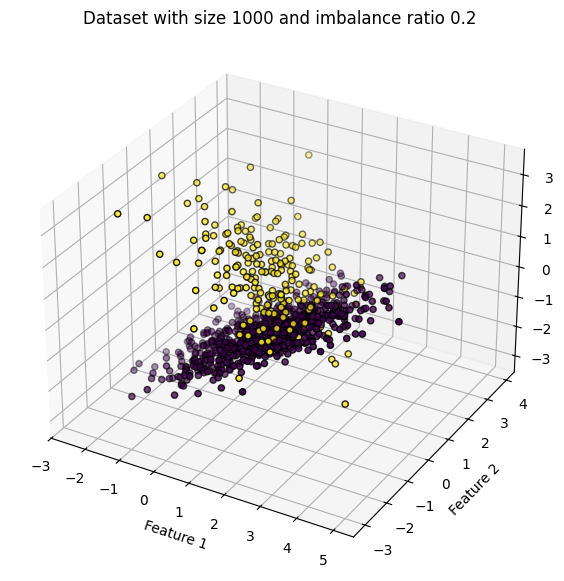

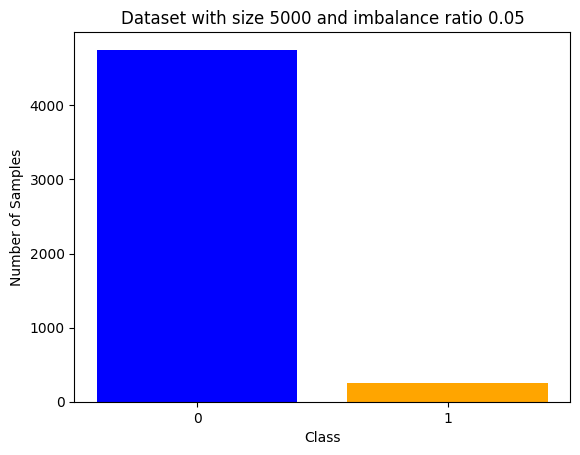

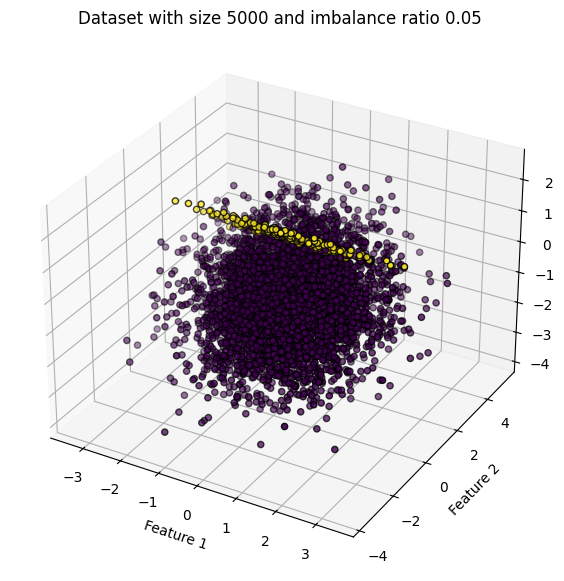

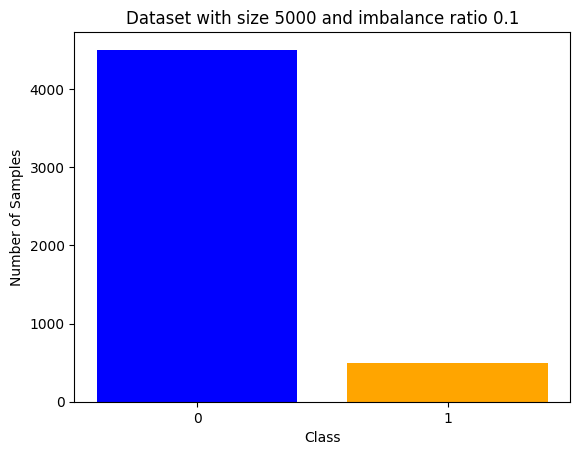

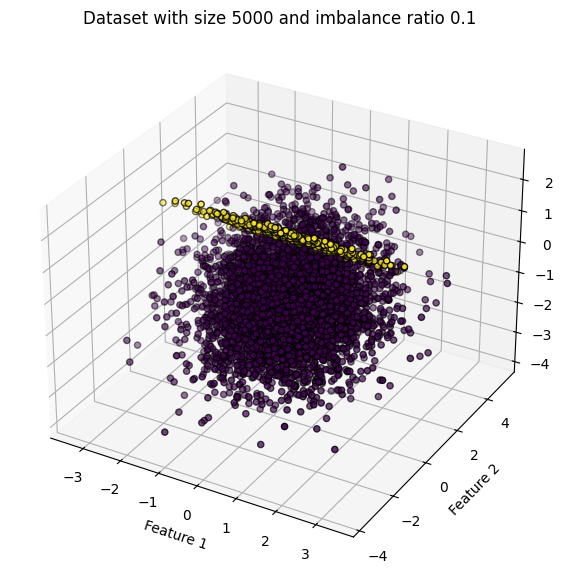

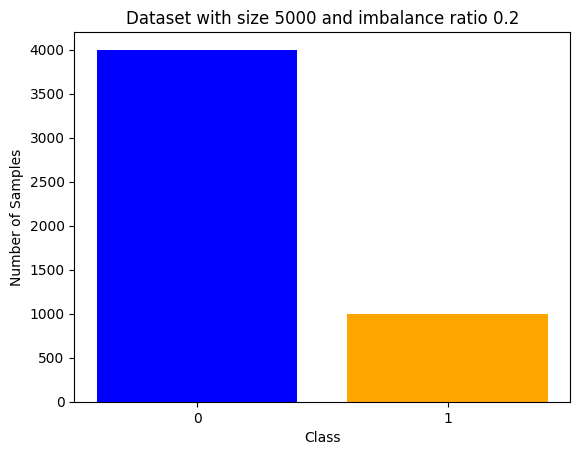

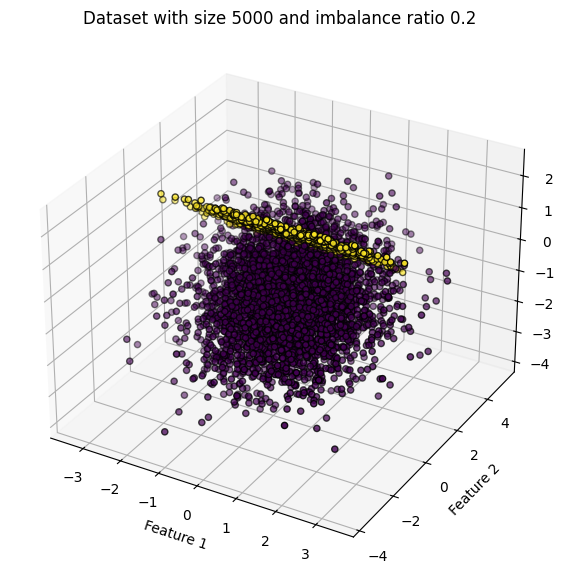

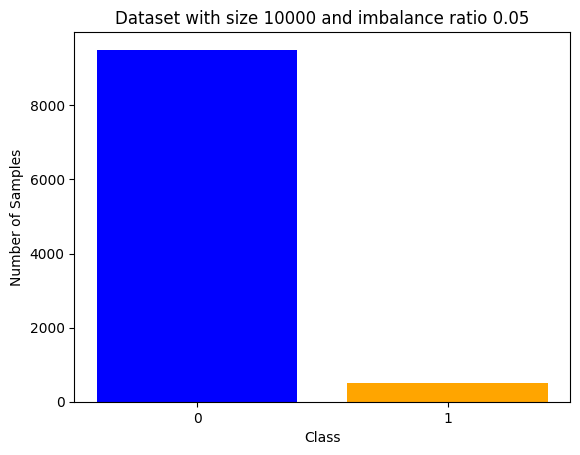

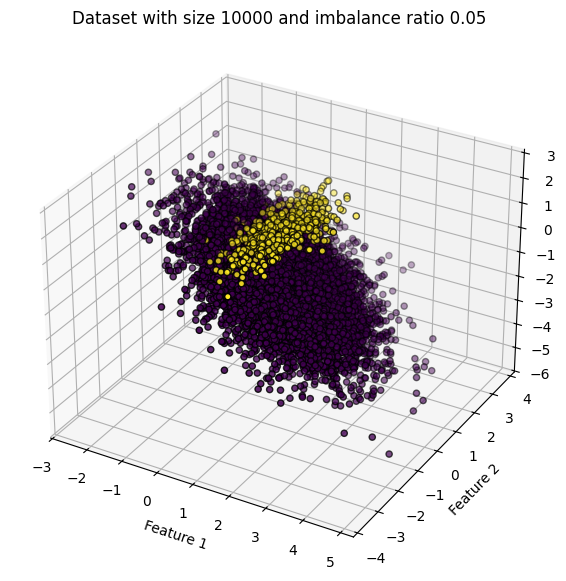

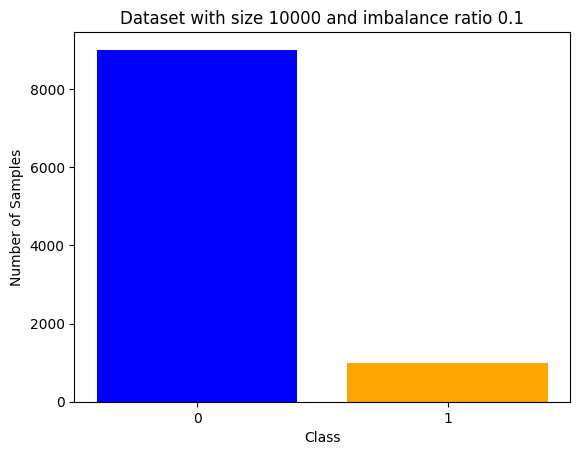

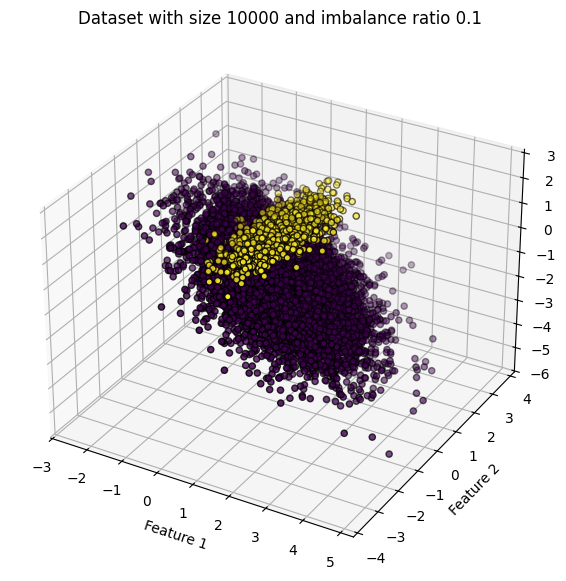

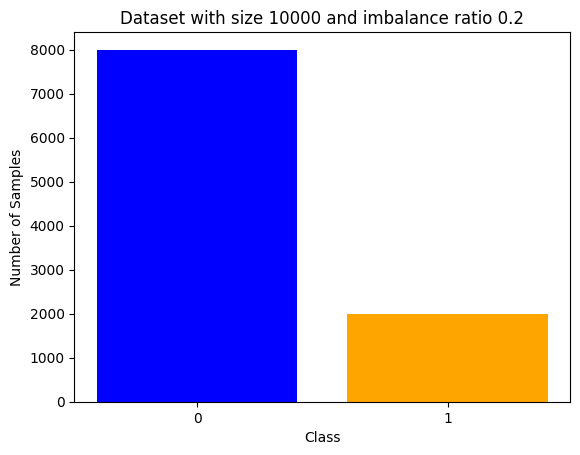

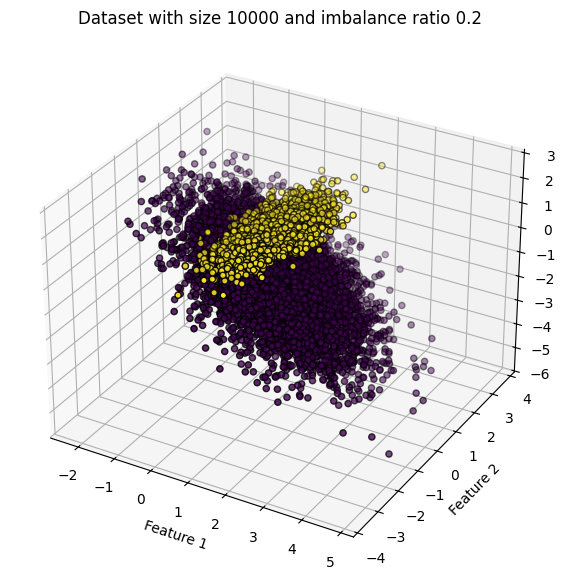

In [24]:
results_list = []

# Define classifiers and configurations to test
# Each tuple includes: (Classifier Name, Classifier Object, Modifier)
classifiers = [
    ("RandomForest", RandomForestClassifier(), "N/A"),
    ("RandomForest with Class Weight", RandomForestClassifier(class_weight="balanced"), "class_weight"),
    ("BalancedRandomForest", BalancedRandomForestClassifier(), "N/A"),
    ("SVM", SVC(), "N/A"),
    ("SVM with Class Weight", SVC(class_weight="balanced"), "class_weight")
]

sampling_strategies = ["N/A", "oversampling", "upsampling", "SMOTE", "undersampling"]
dataset_sizes = [1000, 5000, 10000]
imbalance_ratios = [0.05, 0.1, 0.2]

# Perform evaluations for each dataset size, imbalance ratio, classifier, and sampling strategy
for dataset_size in dataset_sizes:
    for imbalance_ratio in imbalance_ratios:
        X, y = create_imbalanced_dataset(size=dataset_size, imbalance_ratio=imbalance_ratio)

        # Iterate over each classifier and sampling strategy
        for name, clf, modifier in classifiers:
            for sampling in sampling_strategies:
                result = evaluate_model(
                    model=clf, 
                    X=X, 
                    y=y, 
                    modifiers=modifier, 
                    sampling=sampling, 
                    dataset_size=dataset_size, 
                    imbalance_ratio=imbalance_ratio
                )

                result["Classifier Name"] = name
                result["Modifiers"] = modifier
                result["Sampling"] = sampling

                results_list.append(result)

results_df = pd.DataFrame(results_list)
results_df = results_df[
    ["Classifier Name", "Modifiers", "Sampling", "DatasetSize", "% imbalance",
     "Training precision", "Training accuracy", "Training recall", "Training f1", "Training balanced accuracy", "Training size",
     "Testing precision", "Testing accuracy", "Testing recall", "Testing f1", "Testing balanced accuracy", "Testing size"]
]

In [40]:
df1 = results_df.loc[0:24]
df1

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
0,RandomForest,N/A,N/A,1000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,800,1.000000,0.990,0.80,0.881957,0.900000,200
1,RandomForest,N/A,oversampling,1000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,1520,1.000000,0.996,0.92,0.956725,0.960000,200
2,RandomForest,N/A,upsampling,1000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,800,1.000000,0.989,0.78,0.870261,0.890000,200
3,RandomForest,N/A,SMOTE,1000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,1520,0.933333,0.992,0.92,0.919192,0.957895,200
4,RandomForest,N/A,undersampling,1000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,100,0.444719,0.937,1.00,0.614997,0.966842,200
5,RandomForest with Class Weight,class_weight,N/A,1000,5.0,1.000000,0.999750,0.995000,0.997468,0.997500,800,1.000000,0.993,0.86,0.921431,0.930000,200
6,RandomForest with Class Weight,class_weight,oversampling,1000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,1520,1.000000,0.995,0.90,0.945029,0.950000,200
7,RandomForest with Class Weight,class_weight,upsampling,1000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,800,1.000000,0.991,0.82,0.893653,0.910000,200
8,RandomForest with Class Weight,class_weight,SMOTE,1000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,1520,0.933333,0.992,0.92,0.919192,0.957895,200
9,RandomForest with Class Weight,class_weight,undersampling,1000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,100,0.448342,0.938,1.00,0.618562,0.967368,200


In [41]:
df2 = results_df.loc[25:49]
df2

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
25,RandomForest,N/A,N/A,1000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,800,1.000000,0.985,0.85,0.918603,0.925000,200
26,RandomForest,N/A,oversampling,1000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,1440,0.978363,0.983,0.85,0.908908,0.923889,200
27,RandomForest,N/A,upsampling,1000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,800,0.989474,0.985,0.86,0.919434,0.929444,200
28,RandomForest,N/A,SMOTE,1000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,1440,0.913536,0.983,0.92,0.916025,0.955000,200
29,RandomForest,N/A,undersampling,1000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,200,0.827246,0.979,1.00,0.905238,0.988333,200
30,RandomForest with Class Weight,class_weight,N/A,1000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,800,1.000000,0.986,0.86,0.924293,0.930000,200
31,RandomForest with Class Weight,class_weight,oversampling,1000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,1440,0.989474,0.985,0.86,0.919434,0.929444,200
32,RandomForest with Class Weight,class_weight,upsampling,1000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,800,1.000000,0.984,0.84,0.912597,0.920000,200
33,RandomForest with Class Weight,class_weight,SMOTE,1000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,1440,0.905895,0.981,0.91,0.906654,0.949444,200
34,RandomForest with Class Weight,class_weight,undersampling,1000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,200,0.862978,0.984,1.00,0.926206,0.991111,200


In [42]:
df3 = results_df.loc[50:74]
df3

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
50,RandomForest,N/A,N/A,1000,20.0,1.000000,0.999750,0.998750,0.999373,0.999375,800,0.989181,0.977,0.895,0.939568,0.946250,200
51,RandomForest,N/A,oversampling,1000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,1280,0.973812,0.975,0.900,0.935110,0.946875,200
52,RandomForest,N/A,upsampling,1000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,800,0.989189,0.975,0.885,0.933950,0.941250,200
53,RandomForest,N/A,SMOTE,1000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,1280,0.926409,0.967,0.910,0.917329,0.945625,200
54,RandomForest,N/A,undersampling,1000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,400,0.923232,0.983,1.000,0.959664,0.989375,200
55,RandomForest with Class Weight,class_weight,N/A,1000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,800,0.994595,0.979,0.900,0.944835,0.949375,200
56,RandomForest with Class Weight,class_weight,oversampling,1000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,1280,0.963783,0.974,0.905,0.933039,0.948125,200
57,RandomForest with Class Weight,class_weight,upsampling,1000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,800,0.978947,0.974,0.890,0.932038,0.942500,200
58,RandomForest with Class Weight,class_weight,SMOTE,1000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,1280,0.917317,0.965,0.910,0.912956,0.944375,200
59,RandomForest with Class Weight,class_weight,undersampling,1000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,400,0.902544,0.978,1.000,0.948335,0.986250,200


In [43]:
df4 = results_df.loc[75:99]
df4

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
75,RandomForest,N/A,N/A,5000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.894048,0.9856,0.808,0.847896,0.901474,1000
76,RandomForest,N/A,oversampling,5000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,7600,0.839486,0.9846,0.856,0.846803,0.923684,1000
77,RandomForest,N/A,upsampling,5000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.865033,0.9816,0.752,0.802965,0.872842,1000
78,RandomForest,N/A,SMOTE,5000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,7600,0.765028,0.9820,0.924,0.836614,0.954526,1000
79,RandomForest,N/A,undersampling,5000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,500,0.499159,0.9494,1.000,0.665268,0.973368,1000
80,RandomForest with Class Weight,class_weight,N/A,5000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.884945,0.9844,0.792,0.835152,0.893263,1000
81,RandomForest with Class Weight,class_weight,oversampling,5000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,7600,0.838239,0.9850,0.868,0.852144,0.929579,1000
82,RandomForest with Class Weight,class_weight,upsampling,5000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.862685,0.9822,0.768,0.811221,0.880737,1000
83,RandomForest with Class Weight,class_weight,SMOTE,5000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,7600,0.769077,0.9824,0.928,0.840427,0.956632,1000
84,RandomForest with Class Weight,class_weight,undersampling,5000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,500,0.486780,0.9470,1.000,0.654412,0.972105,1000


In [44]:
df5 = results_df.loc[100:124]
df5

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
100,RandomForest,N/A,N/A,5000,10.0,1.000000,0.999950,0.999500,0.999750,0.999750,4000,0.917148,0.9812,0.894,0.904778,0.942444,1000
101,RandomForest,N/A,oversampling,5000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,7200,0.890390,0.9822,0.938,0.913378,0.962556,1000
102,RandomForest,N/A,upsampling,5000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.900874,0.9790,0.888,0.894197,0.938556,1000
103,RandomForest,N/A,SMOTE,5000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,7200,0.845681,0.9782,0.958,0.898024,0.969222,1000
104,RandomForest,N/A,undersampling,5000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,1000,0.792562,0.9738,1.000,0.884232,0.985444,1000
105,RandomForest with Class Weight,class_weight,N/A,5000,10.0,1.000000,0.999950,0.999500,0.999750,0.999750,4000,0.916910,0.9816,0.898,0.907074,0.944444,1000
106,RandomForest with Class Weight,class_weight,oversampling,5000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,7200,0.884647,0.9806,0.928,0.905479,0.957222,1000
107,RandomForest with Class Weight,class_weight,upsampling,5000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.897983,0.9778,0.878,0.887661,0.933444,1000
108,RandomForest with Class Weight,class_weight,SMOTE,5000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,7200,0.844176,0.9782,0.960,0.898151,0.970111,1000
109,RandomForest with Class Weight,class_weight,undersampling,5000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,1000,0.792718,0.9738,1.000,0.884286,0.985444,1000


In [45]:
df6 = results_df.loc[125:149]
df6

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
125,RandomForest,N/A,N/A,5000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.934753,0.9768,0.951,0.942508,0.967125,1000
126,RandomForest,N/A,oversampling,5000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,6400,0.924809,0.9774,0.966,0.944826,0.973125,1000
127,RandomForest,N/A,upsampling,5000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.927110,0.9726,0.937,0.931892,0.959250,1000
128,RandomForest,N/A,SMOTE,5000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,6400,0.920187,0.9782,0.976,0.947175,0.977375,1000
129,RandomForest,N/A,undersampling,5000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,2000,0.907098,0.9794,1.000,0.951161,0.987125,1000
130,RandomForest with Class Weight,class_weight,N/A,5000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.931671,0.9758,0.949,0.940107,0.965750,1000
131,RandomForest with Class Weight,class_weight,oversampling,5000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,6400,0.924227,0.9776,0.968,0.945448,0.974000,1000
132,RandomForest with Class Weight,class_weight,upsampling,5000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.930286,0.9748,0.945,0.937540,0.963625,1000
133,RandomForest with Class Weight,class_weight,SMOTE,5000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,6400,0.916322,0.9776,0.978,0.945968,0.977750,1000
134,RandomForest with Class Weight,class_weight,undersampling,5000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,2000,0.909580,0.9800,1.000,0.952521,0.987500,1000


In [46]:
df7 = results_df.loc[150:174]
df7

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
150,RandomForest,N/A,N/A,10000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,8000,0.983483,0.9964,0.944,0.963284,0.971579,2000
151,RandomForest,N/A,oversampling,10000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,15200,0.966050,0.9959,0.952,0.958839,0.975105,2000
152,RandomForest,N/A,upsampling,10000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,8000,0.981268,0.9960,0.938,0.959077,0.968526,2000
153,RandomForest,N/A,SMOTE,10000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,15200,0.917680,0.9941,0.970,0.942836,0.982684,2000
154,RandomForest,N/A,undersampling,10000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,1000,0.806180,0.9879,1.000,0.892414,0.993632,2000
155,RandomForest with Class Weight,class_weight,N/A,10000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,8000,0.983414,0.9966,0.948,0.965314,0.973579,2000
156,RandomForest with Class Weight,class_weight,oversampling,10000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,15200,0.965848,0.9958,0.950,0.957775,0.974105,2000
157,RandomForest with Class Weight,class_weight,upsampling,10000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,8000,0.979270,0.9962,0.944,0.961243,0.971474,2000
158,RandomForest with Class Weight,class_weight,SMOTE,10000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,15200,0.912648,0.9938,0.970,0.940181,0.982526,2000
159,RandomForest with Class Weight,class_weight,undersampling,10000,5.0,1.000000,1.000000,1.000000,1.000000,1.000000,1000,0.790560,0.9867,1.000,0.882848,0.993000,2000


In [47]:
df8 = results_df.loc[175:199]
df8

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
175,RandomForest,N/A,N/A,10000,10.0,1.000000,0.999975,0.999750,0.999875,0.999875,8000,0.987763,0.9944,0.956,0.971504,0.977333,2000
176,RandomForest,N/A,oversampling,10000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,14400,0.973881,0.9937,0.963,0.968307,0.980056,2000
177,RandomForest,N/A,upsampling,10000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,8000,0.988734,0.9945,0.956,0.971976,0.977389,2000
178,RandomForest,N/A,SMOTE,10000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,14400,0.939061,0.9907,0.970,0.954247,0.981500,2000
179,RandomForest,N/A,undersampling,10000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,2000,0.901178,0.9890,1.000,0.947948,0.993889,2000
180,RandomForest with Class Weight,class_weight,N/A,10000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,8000,0.983682,0.9941,0.957,0.970063,0.977611,2000
181,RandomForest with Class Weight,class_weight,oversampling,10000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,14400,0.973755,0.9936,0.962,0.967766,0.979556,2000
182,RandomForest with Class Weight,class_weight,upsampling,10000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,8000,0.984690,0.9944,0.959,0.971592,0.978667,2000
183,RandomForest with Class Weight,class_weight,SMOTE,10000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,14400,0.941903,0.9911,0.971,0.956176,0.982167,2000
184,RandomForest with Class Weight,class_weight,undersampling,10000,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,2000,0.901978,0.9891,1.000,0.948394,0.993944,2000


In [48]:
df9 = results_df.loc[200:224]
df9

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
200,RandomForest,N/A,N/A,10000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,8000,0.986239,0.9912,0.9695,0.977782,0.983063,2000
201,RandomForest,N/A,oversampling,10000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,12800,0.979409,0.9907,0.9740,0.976653,0.984437,2000
202,RandomForest,N/A,upsampling,10000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,8000,0.984230,0.9906,0.9685,0.976296,0.982313,2000
203,RandomForest,N/A,SMOTE,10000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,12800,0.969317,0.9896,0.9790,0.974092,0.985625,2000
204,RandomForest,N/A,undersampling,10000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.969998,0.9938,1.0000,0.984754,0.996125,2000
205,RandomForest with Class Weight,class_weight,N/A,10000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,8000,0.984263,0.9911,0.9710,0.977564,0.983563,2000
206,RandomForest with Class Weight,class_weight,oversampling,10000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,12800,0.980898,0.9914,0.9760,0.978402,0.985625,2000
207,RandomForest with Class Weight,class_weight,upsampling,10000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,8000,0.983807,0.9914,0.9730,0.978367,0.984500,2000
208,RandomForest with Class Weight,class_weight,SMOTE,10000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,12800,0.969805,0.9896,0.9785,0.974078,0.985437,2000
209,RandomForest with Class Weight,class_weight,undersampling,10000,20.0,1.000000,1.000000,1.000000,1.000000,1.000000,4000,0.971376,0.9941,1.0000,0.985472,0.996312,2000


In [49]:
best_test_precision = results_df[results_df['Testing precision'] == results_df['Testing precision'].max()]
best_test_accuracy = results_df[results_df['Testing accuracy'] == results_df['Testing accuracy'].max()]
best_test_recall = results_df[results_df['Testing recall'] == results_df['Testing recall'].max()]
best_test_f1 = results_df[results_df['Testing f1'] == results_df['Testing f1'].max()]
best_test_balanced_accuracy = results_df[results_df['Testing balanced accuracy'] == results_df['Testing balanced accuracy'].max()]

In [50]:
best_test_precision

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
0,RandomForest,N/A,N/A,1000,5.0,1.000000,1.00000,1.000000,1.000000,1.000000,800,1.0,0.990,0.800,0.881957,0.9000,200
1,RandomForest,N/A,oversampling,1000,5.0,1.000000,1.00000,1.000000,1.000000,1.000000,1520,1.0,0.996,0.920,0.956725,0.9600,200
2,RandomForest,N/A,upsampling,1000,5.0,1.000000,1.00000,1.000000,1.000000,1.000000,800,1.0,0.989,0.780,0.870261,0.8900,200
5,RandomForest with Class Weight,class_weight,N/A,1000,5.0,1.000000,0.99975,0.995000,0.997468,0.997500,800,1.0,0.993,0.860,0.921431,0.9300,200
6,RandomForest with Class Weight,class_weight,oversampling,1000,5.0,1.000000,1.00000,1.000000,1.000000,1.000000,1520,1.0,0.995,0.900,0.945029,0.9500,200
7,RandomForest with Class Weight,class_weight,upsampling,1000,5.0,1.000000,1.00000,1.000000,1.000000,1.000000,800,1.0,0.991,0.820,0.893653,0.9100,200
11,BalancedRandomForest,N/A,oversampling,1000,5.0,1.000000,1.00000,1.000000,1.000000,1.000000,1520,1.0,0.995,0.900,0.945029,0.9500,200
15,SVM,N/A,N/A,1000,5.0,1.000000,0.98825,0.765000,0.866338,0.882500,800,1.0,0.988,0.760,0.857190,0.8800,200
17,SVM,N/A,upsampling,1000,5.0,1.000000,0.98925,0.803039,0.887004,0.901520,800,1.0,0.990,0.800,0.881957,0.9000,200
25,RandomForest,N/A,N/A,1000,10.0,1.000000,1.00000,1.000000,1.000000,1.000000,800,1.0,0.985,0.850,0.918603,0.9250,200


In [51]:
best_test_accuracy

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
155,RandomForest with Class Weight,class_weight,N/A,10000,5.0,1.0,1.0,1.0,1.0,1.0,8000,0.983414,0.9966,0.948,0.965314,0.973579,2000


In [52]:
best_test_recall

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
4,RandomForest,N/A,undersampling,1000,5.0,1.0,1.0,1.0,1.0,1.0,100,0.444719,0.9370,1.0,0.614997,0.966842,200
9,RandomForest with Class Weight,class_weight,undersampling,1000,5.0,1.0,1.0,1.0,1.0,1.0,100,0.448342,0.9380,1.0,0.618562,0.967368,200
14,BalancedRandomForest,N/A,undersampling,1000,5.0,1.0,1.0,1.0,1.0,1.0,100,0.435231,0.9340,1.0,0.605287,0.965263,200
29,RandomForest,N/A,undersampling,1000,10.0,1.0,1.0,1.0,1.0,1.0,200,0.827246,0.9790,1.0,0.905238,0.988333,200
34,RandomForest with Class Weight,class_weight,undersampling,1000,10.0,1.0,1.0,1.0,1.0,1.0,200,0.862978,0.9840,1.0,0.926206,0.991111,200
39,BalancedRandomForest,N/A,undersampling,1000,10.0,1.0,1.0,1.0,1.0,1.0,200,0.872294,0.9850,1.0,0.931053,0.991667,200
54,RandomForest,N/A,undersampling,1000,20.0,1.0,1.0,1.0,1.0,1.0,400,0.923232,0.9830,1.0,0.959664,0.989375,200
59,RandomForest with Class Weight,class_weight,undersampling,1000,20.0,1.0,1.0,1.0,1.0,1.0,400,0.902544,0.9780,1.0,0.948335,0.986250,200
64,BalancedRandomForest,N/A,undersampling,1000,20.0,1.0,1.0,1.0,1.0,1.0,400,0.918354,0.9820,1.0,0.957195,0.988750,200
79,RandomForest,N/A,undersampling,5000,5.0,1.0,1.0,1.0,1.0,1.0,500,0.499159,0.9494,1.0,0.665268,0.973368,1000


In [53]:
best_test_f1

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
214,BalancedRandomForest,N/A,undersampling,10000,20.0,1.0,1.0,1.0,1.0,1.0,4000,0.97419,0.9947,1.0,0.986925,0.996687,2000


In [54]:
best_test_balanced_accuracy

,Classifier Name,Modifiers,Sampling,DatasetSize,% imbalance,Training precision,Training accuracy,Training recall,Training f1,Training balanced accuracy,Training size,Testing precision,Testing accuracy,Testing recall,Testing f1,Testing balanced accuracy,Testing size
214,BalancedRandomForest,N/A,undersampling,10000,20.0,1.0,1.0,1.0,1.0,1.0,4000,0.97419,0.9947,1.0,0.986925,0.996687,2000


Looking at the results, we can conclude several things:

* First, the best precision on the testing set is never reached when we undersampled the majority class and is always reached when the dataset is small (with a size of $1000$ in this case). The best testing precision is achieved with small datasets because the model can better focus on learning the minority class patterns without being overwhelmed by the majority class. However, undersampling the majority class, while improving recall, can hurt precision as the model might overfit on the small undersampled dataset and incorrectly classify some majority class instances.

* Then, we see that undersampling always lead to a recall of 1. The reason undersampling always leads to a recall of 1 is that this technique ensures the model sees and learns every instance of the minority class, thereby correctly classifying all minority class instances in both training and testing sets. This results in perfect recall (1.0), as undersampling addresses the class imbalance by forcing the model to focus on the minority class without being overwhelmed by the majority class.

* Finally, we observe that the same model reaches the best performance in term of f1 score and balanced accuracy (a Balanced Random Forest).